## Vmax tracking using IBTrACS

v05: Here, Rmax is never observed, thus 

X = [Vmax, Rmax_CK, R34, f, U, V] is of size 6

Y = [Vmax, R34, f, U, V] is of size 5

H and R have size 5 x 5

In [12]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable              # Convert arrays to tensors
from torch.utils.data import Dataset, DataLoader # Create a Dataset class to combine with DataLoader (= mini batches selection)
import pytorch_lightning as pl

# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
# from scipy.interpolate import griddata
from datetime import datetime
from sklearn.linear_model import LinearRegression

# Custom
import functions as f

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
print('{} GPU(s) available'.format(torch.cuda.device_count()))

Using cuda device
1 GPU(s) available


In [3]:
### VARIABLES TO CONSIDER
'''Initial dataset has 147 variables, so we select only a subset of these'''
# storm speed, time, dist2land, usa_r64, usa_r50
params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw', 'storm_speed', 'storm_dir'] 
additional_info    = ['numobs', 'sid', 'basin', 'name', 'usa_agency', 'iso_time', 'usa_status']

### PARAMS
PARAMS = {'fcor_boost' : 1,         
         }

### PATHS
PATHS  = {
    # Data
    'ibtracs_data': '/home/arthur/data/ibtracs/IBTrACS.ALL.v04r00.nc', # '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc'
    # Save
    'save_path':     '/home/arthur/results/TCsLifeMonitFromObs/descriptive_stats/',
    'save_csv_path': '/home/arthur/results/TCsLifeMonitFromObs/descriptive_stats/csv_files/',
}

In [4]:
### OPEN DATASET
ds_ibt_raw = xr.open_dataset(PATHS['ibtracs_data'])
ds_ibt     = ds_ibt_raw[params_of_interest + additional_info]
# ds_ibt_raw

In [5]:
# ### FILTERS
# # Convert to m/s and km units
# ds_ibt['usa_wind']    *= 0.5144
# ds_ibt['storm_speed'] *= 0.5144
# ds_ibt['usa_r34']     *= 1.852
# ds_ibt['usa_rmw']     *= 1.852

# ### 1) FILTERS BY YEAR, EMPTY R34, CATEGORY, RMAX INTERESTING TIME SERIES
# # By year
# start_date = np.datetime64('2000-01-01')
# fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
# ds_ibt     = ds_ibt.isel(storm=slice(fsi, -1))
# # Average by quadrant (R34 assumption)
# # ds_ibt     = ds_ibt.mean(dim='quadrant', skipna=True) # Relax this assumption to study the asymmetry
# # By category
# for s in tqdm(range(len(ds_ibt['storm']))):
#     da = ds_ibt.isel(storm=s)['usa_wind']
#     if da.max(dim='date_time', skipna=True) < 33: # >= Cat.1 according to Saffir Simpson scale, 64 is in knts
#         ds_ibt.isel(storm=s)['usa_wind'] *= np.nan  

# # # Keep only interesting time series, i.e containing sufficiently long sequences of valid Rmax values
# for s in tqdm(range(len(ds_ibt['storm']))):
#     da = ds_ibt.isel(storm=s)['usa_rmw']
#     # Longest valid sequence
#     # if np.max(np.diff(np.where(np.isnan(da)))) < 8: # Count maximum valid sequence and filter it out if less than 1 day
#     #     ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan
#     # Number of valid values
#     if np.count_nonzero(~np.isnan(da)) < 24: # Count the number of valid usa_rmw values and filter it out if less than 24 values
#         ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan   
# # Drop NaNs
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_wind']) # Much quicker to drop NaNs only at the end
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

# print("Total samples after (1): ", len(ds_ibt['storm']))

# ### 2) FINAL DATASET
# ### Keep longest valid sequence if it represents more than 60% of the TC life cycle
# # Both for RMW and R34
# life_cyc_percent_thresh = 0.6

# for s in tqdm(range(len(ds_ibt['storm']))):
#         ds      = ds_ibt.isel(storm=s)
#         # Compute life cycle length
#         cyc_len = np.where(np.isnan(ds['usa_lat']))[0][0]
#         for param in ['usa_r34', 'usa_rmw']:
#         # for param in ['usa_rmw']:
#             # Compute length of longest valid sequence
#             val_len = np.max(np.diff(np.concatenate(([0], np.where(np.isnan(ds[param]))[0]), axis=0)))
#             if val_len < life_cyc_percent_thresh * cyc_len:
#                 # print('Index {}, Cyc_len = {}, val_len = {}'.format(s, cyc_len, val_len))
#                 ds[param] *= np.nan
                
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

# print("Total samples after (2): ", len(ds_ibt['storm'])) 

# ### 3) ADD CORIOLIS
# ds_ibt['fcor'] = f.coriolis(np.abs(ds_ibt['usa_lat'])) * PARAMS['fcor_boost']
                
# ### 4) FLIP TCs of Southern hemisphere
# ### Take the symmetric with respect to Equator
# ### So storm_dir = PI - storm_dir
# ds_ibt.where(ds_ibt['lat'] < 0)['storm_dir'] = 180 - ds_ibt['storm_dir']
# # Then project to (u, v) ref.
# ds_ibt['u_trans'] = ds_ibt['storm_speed'] * np.sin(np.deg2rad(ds_ibt['storm_dir']))
# ds_ibt['v_trans'] = ds_ibt['storm_speed'] * np.cos(np.deg2rad(ds_ibt['storm_dir']))
# # plt.hist(np.array(ds_ibt['u_trans']).flatten()) # Check gaussianity

# ### 5) COMPUTE RMAX_CK22
# ds_ibt['rmax_ck22'] = f.get_rmax_ck22(
#     Vmax=ds_ibt['usa_wind'], R17=ds_ibt['usa_r34'], fcor=f.coriolis(np.abs(ds_ibt['usa_lat'])), 
#     intercept=0.459, coef1=0.00534, coef2=-0.00337
# ) / 1000

In [6]:
# ### SAVE
# ds_ibt.to_netcdf(PATHS['save_path'] + 'ds_ibtracs_NA.nc')

In [9]:
# ### OPEN
ds_ibt = xr.open_dataset(PATHS['save_path'] + 'ds_ibtracs_ALL.nc')
# ds_ibt

(array([2.4307e+04, 5.5220e+03, 8.8300e+02, 2.1600e+02, 5.3000e+01,
        2.7000e+01, 2.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([  0.      ,  40.092667,  80.18533 , 120.278   , 160.37067 ,
        200.46333 , 240.556   , 280.64868 , 320.74133 , 360.83398 ,
        400.92667 ], dtype=float32),
 <BarContainer object of 10 artists>)

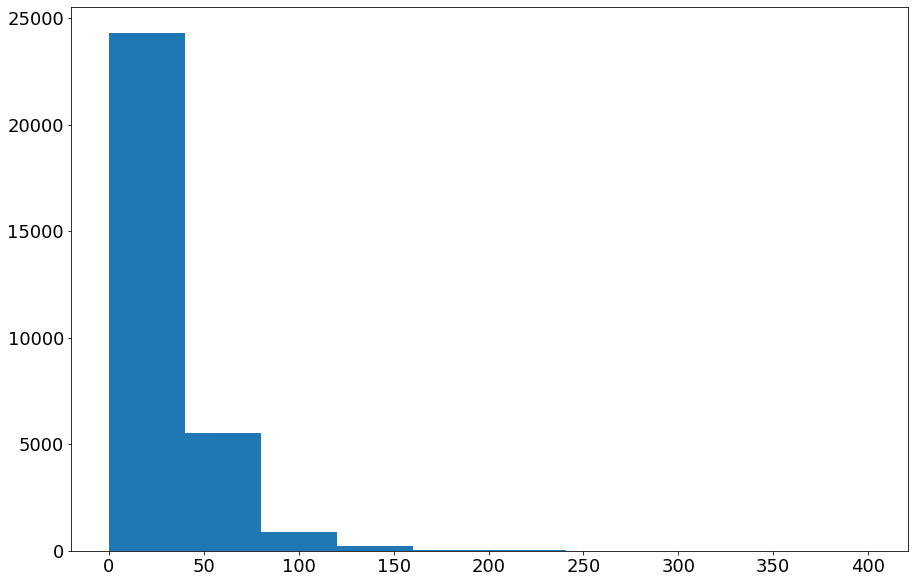

In [26]:
plt.hist(np.array(ds_ibt['usa_r34'].std(dim='quadrant', skipna=True)).flatten())

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


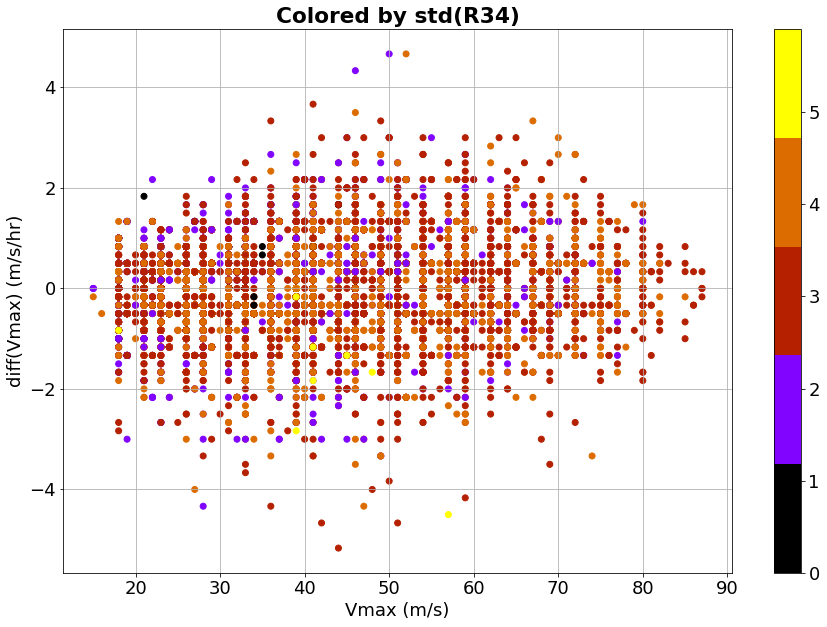

In [28]:
cmap         = cm.get_cmap('gnuplot', 5)

vmaxs      = np.array(ds_ibt['usa_wind'])
vmaxs_diff = np.gradient(vmaxs, 3, axis=1)

plt.scatter(vmaxs, vmaxs_diff, c=np.log(ds_ibt['usa_r34'].std(dim='quadrant', skipna=True)), cmap=cmap)

plt.title('Colored by std(R34)', weight='bold')
plt.xlabel('Vmax (m/s)');plt.ylabel('diff(Vmax) (m/s/hr)')
plt.grid();plt.colorbar()

(array([3.0000e+00, 1.6000e+01, 1.8700e+02, 2.2164e+04, 7.3500e+03,
        9.0000e+01, 1.3000e+01, 4.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-64.791664 , -48.129166 , -31.466663 , -14.804164 ,   1.8583359,
         18.520836 ,  35.183334 ,  51.845837 ,  68.50834  ,  85.17084  ,
        101.833336 ], dtype=float32),
 <BarContainer object of 10 artists>)

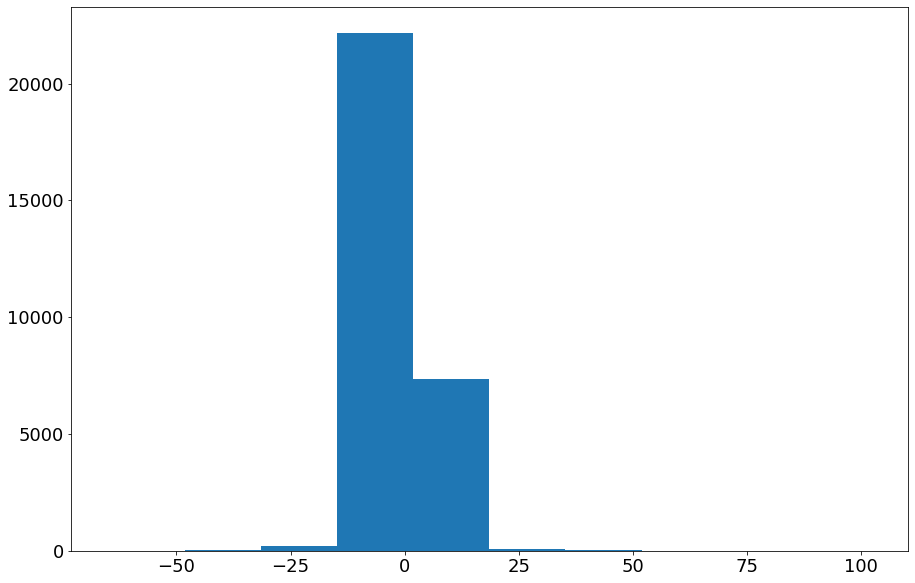

In [34]:
plt.hist(r34s_diff.flatten())

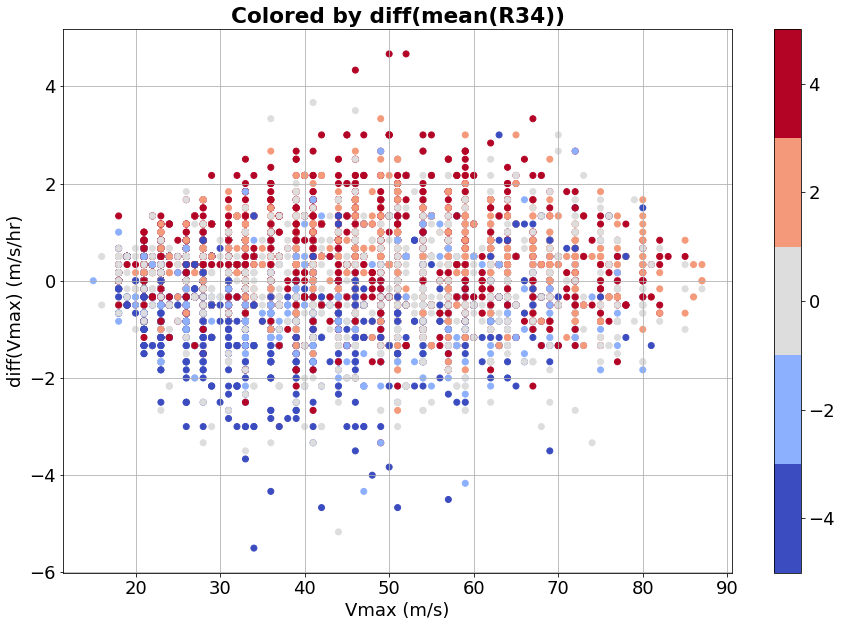

In [38]:
cmap         = cm.get_cmap('coolwarm', 5)

vmaxs      = np.array(ds_ibt['usa_wind'])
vmaxs_diff = np.gradient(vmaxs, 3, axis=1)
r34s       = np.array(ds_ibt['usa_r34'].mean(dim='quadrant', skipna=True))
r34s_diff  = np.gradient(r34s, 3, axis=1)

plt.scatter(vmaxs, vmaxs_diff, c=r34s_diff, vmin=-5, vmax=5, cmap=cmap)

plt.title('Colored by diff(mean(R34))', weight='bold')
plt.xlabel('Vmax (m/s)');plt.ylabel('diff(Vmax) (m/s/hr)')
plt.grid();plt.colorbar()

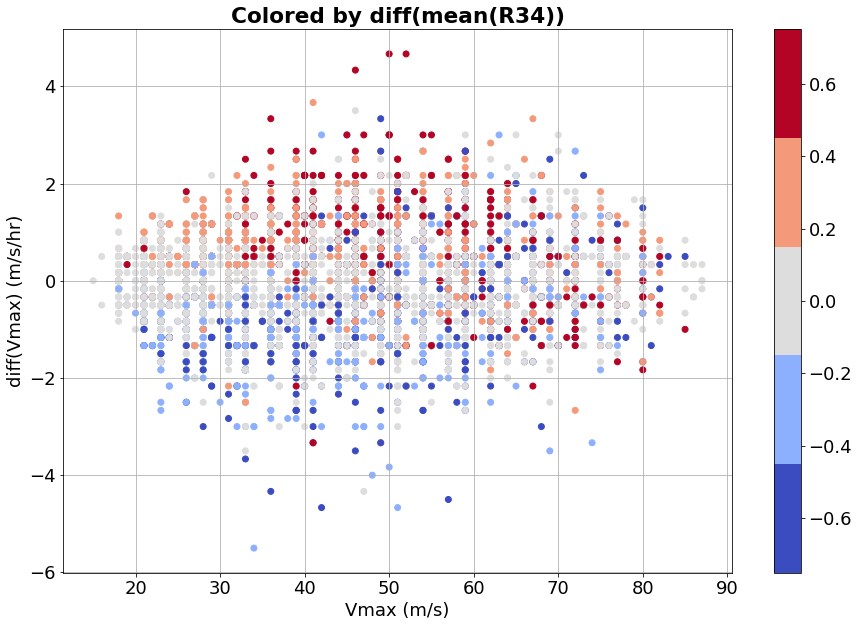

In [46]:
cmap         = cm.get_cmap('coolwarm', 5)

vmaxs      = np.array(ds_ibt['usa_wind'])
vmaxs_diff = np.gradient(vmaxs, 3, axis=1)
r34_rmaxs  = np.array(ds_ibt['usa_r34'].mean(dim='quadrant', skipna=True) / ds_ibt['usa_rmw'])
r34_rmaxs_diff = np.gradient(r34_rmaxs, 3, axis=1)

plt.scatter(vmaxs, vmaxs_diff, c=r34_rmaxs_diff, vmin=-0.75, vmax=0.75, cmap=cmap)

plt.title('Colored by diff(R34 / Rmax)', weight='bold')
plt.xlabel('Vmax (m/s)');plt.ylabel('diff(Vmax) (m/s/hr)')
plt.grid();plt.colorbar()